# Neural Networks

## Prerequisites
- [Fundamental Python]()
- [Linear modeals and optimisation]()

## Why do the simple models struggle with meaningful tasks?

Whereas the size of a house and its price might be linearly correlated, the pixel intensities of an image are certainly not linearly correlated with whether it contains a dog or a cat.

![](./images/complex-fn.png)

We need to build much more complex models to solve harder problems.

## Can we build more complex models by combining many simple transformations?

The models we have just seen apply a single transformation to the data. However most problems of practical interest can't be solved using such simple models. 

Models with greater **capacity** are those which are able to model more complicated functions.

A single linear transformation (multiplication by weights of model) stretches the input space by a certain factor in some direction, and adding a constant (bias) shifts it. 
We call models which apply  
What if we applied more than one **layer** of transformations to our inputs, to create a **deep model**. Would we be able to increase the capacity of our model and make it able to model more complex input-output relationships, particularly non-linear ones?

![](./images/shallow-vs-deep.png)

...well, not quite yet.

...if we repeatedly apply a linear transformation, the input can be factorised out of the output, showing that many repeated linear functions are eventually equal to a single linear transformation.

![](./images/factor-proof.png)

## So how can we increase the capacity of our models?

We want to be able to model non-linear functions, so let's try to throw in some non-linear transformations into our model.

![](./images/activation.png)

These non-linear functions prevent the input being able to be factorised out of the model. Hence the overall transformation can represent non-linear input-output relationships.

We call these non-linear functions **activation functions**.

However, It's not like we want to introduce really complicated functions into our model - ideally we wouldn't even have to and we could keep things simple. So let's try and complicate things only a minimal amount by keeping our activation functions very simple.

Here are some common activation functions. ReLU (Rectified Linear Unit) is by far the most widely used.

![](./images/activ-fns.png)

Now we have all of the ingredients to fully understand how we can model more complicated functions. Let's look at that all together:

![](./images/full-nn.png)

Guess what? That is a **neural network**. Surprise.

It's just repeated simple linear transformations followed by simple non-linear transformations (activation functions). Simple.

Let's learn some jargon.

![](./images/nn.png)

Neural networks have additional hyperparameters of the depth of the model and the width of each layer. These 

## What can neural networks do?

The motivation that led us to deriving neural networks was that we wanted to model more complex functions. But what functions can a neural network actually represent? Well, as we show below they can actually represent almost all continuous functions. Neural Networks are **general function approximators**.

![](./images/univ-approx.png)

## How can our neural networks learn to model some function?

As we did in the optimisation notebook, we can adjust our model parameters using gradient descent as such:
1. Pass input data forward through model to output a prediction
2. Calculate loss between predicted output and output label
3. Find direction that moving the model parameters in will reduce the error
4. Move model weights (parameters) a small amount in that direction 

![](./images/backprop.png)

Here you can see that many terms reappear when computing the gradients of preceeding layers. 
By caching those terms, we save having to recompute them for these layers nearer the input. This makes finding the gradients of the loss with respect to each weight in the model much more efficient both in terms of memory and speed. 
This process of computing these gradients effectively is called the **backpropagation**.

## Let's prepare our data

Today we are going to look at a dataset called MNIST (em-nist). It consists of 70,000 images of hand drawn digits from 0-9. 



In [2]:
import torch
from torchvision import datasets, transforms

crop_size = 22

traintransforms = []
traintransforms.append(transforms.CenterCrop(crop_size))
traintransforms.append(transforms.ToTensor())
traintransforms = transforms.Compose(traintransforms)

# GET THE TRAINING DATASET
train_data = datasets.MNIST(root='MNIST-data',                        # where is the data (going to be) stored
                            transform=traintransforms,          # transform the data from a PIL image to a tensor
                            train=True,                               # is this training data?
                            download=True                             # should i download it if it's not already here?
                           )

testtransforms = []
testtransforms.append(transforms.RandomCrop(crop_size))
testtransforms.append(transforms.ToTensor())
testtransforms = transforms.Compose(testtransforms)

# GET THE TEST DATASET
test_data = datasets.MNIST(root='MNIST-data',
                           transform=testtransforms,
                           train=False,
                          )

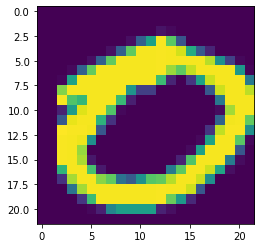

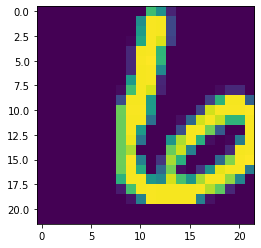

In [3]:
import matplotlib.pyplot as plt
import numpy as np
# PRINT THEIR LENGTHS AND VISUALISE AN EXAMPLE
x = train_data[np.random.randint(0, 300)][0]    # get the first example
plt.imshow(x[0].numpy())
plt.show()
x = test_data[np.random.randint(0, 300)][0]    # get the first example
plt.imshow(x[0].numpy())
plt.show()



## Why should we not tune our hyperparameters based on our model's score on the test set?

If we adjust our model's hyperparameters so that it performs well on the test set, then we are 

This is like training for a test and evaluating your performance based on how well you can answer the exact questions that come up.
In real life you are unlikely to encounter exactly the same challenges, and so by training on them you will overfit, and not be able to generalise to *different* unseen answers.

You may find that a certain set of hyperparameters perform well on the test set, but then fail to perform as well in the wild. 
Analagously, you may find that a particular 

## What else can we test them on? 

We can take some of the data that we plan to train the neural network's weights on and separate it from that main training set. 
We can then use this split-off data to validate that the current hyperparameters will make our model to perform well on unseen data (both the validation set and the test set are unseen).

PyTorch has a utility method `torch.utils.data.random_split()` that makes it easy to randomly split a dataset. Check out the [docs](https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split) here.

In [4]:
# FURTHER SPLIT THE TRAINING INTO TRAINING AND VALIDATION
train_data, val_data = torch.utils.data.random_split(train_data, [50000, 10000])    # split into 50K training & 10K validation


## Why should we not pass the whole dataset through the model for each update?
We know that to perform gradient based optimisation we need to pass inputs through the model (forward pass), and then compute the loss and find how it changes with respect to each of our model's parameters (backward pass). Modern datasets can be abslutely huge. This means that the forward pass can take a long time, as the function which our model represents has to be applied to each and every input given to it for a forward pass.

## Why not just pass a single datapoint to the model for each update?
We want our model to perform well on all examples, not just single examples. So we want to compute the loss and associated gradients over several examples to get an average

## Mini-batch training
The modern way to do training is neither full-batch (whole dataset) or fully stochastic (single datapoint). Instead we use mini-batch training, where we sample several (but not all) datapoints to compute a sample of the gradient, which we then use to update the model. The size of the mini-batch is called the **batch size**. Mini-batches are commonly incorrectly referred to as batches, but it's not that deep.

We will experiment with the effect of batch size on the training later.

## PyTorch's `DataLoader` 
PyTorch has a handy utility called a `DataLoader` which can pass us our data in mini-batches of a specified batch size. It can also shuffle them for us.

Let's use `torch.data.DataLoader` to create data loaders from our train, validation and test datasets now. Hint: look at the [docs](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)

In [5]:
batch_size = 128

# MAKE TRAINING DATALOADER
train_loader = torch.utils.data.DataLoader(
    train_data,
    shuffle=True,
    batch_size=batch_size
)

# MAKE VALIDATION DATALOADER
val_loader = torch.utils.data.DataLoader(
    val_data,
    shuffle=True,
    batch_size=batch_size
)

# MAKE TEST DATALOADER
test_loader = torch.utils.data.DataLoader(
    test_data,
    shuffle=True,
    batch_size=batch_size
)

## Binary classification vs multiclass classification

In binary classification the output must be either true or false. Either the example falls into this class, or it doesn't. We have seen that we can represent this by our model having a single output node whose value is forced between 0 and 1, and as such represents a confidence in the fact that the example belongs to the positive class. Alternatively, still for binary classification, we could have two output nodes, where the value of the first represents the confidence that the input belongs to the positive class (true/class 1) and the value of the second represents the confidence that the input belongs to the negative class (false/class 2). In this case, the values of each output node must be positive and they must sum to 1, because this output layer represents a probability distribution over the output classes. Treating true and false as separate classes with separate output nodes shows us how we can extend this idea to do multiclass classification; we simply add more nodes and ensure that their values are positive and sum to one.

# multiclass diagram

### What function can we use to convert the output layer into a distribution over classes?

The **softmax function** exponentiates each value in a vector to make it positive and then divides each of them by their sum to normalise them (make them sum to 1). This ensures that the vector then can be interpreted as a probability distribution.

# softmax equation

## Making a neural network with PyTorch

PyTorch makes it really easy for us to build complex models that can be improved via gradient based optimisation. It does this by providing a class named `torch.nn.Module`. Our model classes should inherit from this class because it does a few very useful things for us:

1. `torch.nn.Module` keeps track of all `torch.nn.Parameters` that are created within it. So when we add a linear layer to our model, the parameters (matrix of weights) in that layer will be added to a list of our model's parameters. We can retrieve all parameters of our model using its `parameters()` method. We will later pass this (`mymodel.parameters()`) to our optimiser when we tell it that *this* is what it should be optimising.


2. `torch.nn.Module` treats the `forward` method (function) of any child class specially by assigning it to the `__call__` method. That means that running `mymodel.forward(some_data)` is equal to `mymodel(some_data)`. 


It contains many more useful tools

[More detail](https://pytorch.org/tutorials/beginner/nn_tutorial.html) on `torch.nn.Module`
Check out the docs [here]()

Once we have created a class to represent our model, we need to define how it performs the forward pass. What layers of transformations do we need to give it? 
Check out these [docs](https://pytorch.org/docs/stable/nn.html#linear-layers) to look at all the layers PyTorch provides.
Hint: what layer have I linked to?

After we've defined some layers for our model we should implement the forward function that will define what happens when we call an instance of our class. This should pass the argument (our input data) through each of the layers, and apply an activation function to them between each, before returning the transformed input as the output. The output should represent a categorical probability distribution over which class the input belongs to. What shape does it need to be? What function does it need to have applied to it?

In [6]:
import torch.nn.functional as F 

class NeuralNetworkClass(torch.nn.Module):
    def __init__(self):
        super().__init__()    # initialise parent module
        self.layer1 = torch.nn.Linear(crop_size*crop_size, 225)
        self.layer2 = torch.nn.Linear(225, 100)
        self.layer3 = torch.nn.Linear(100, 10)
        
    def forward(self, x):
        x = x.view(-1, crop_size*crop_size)
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.layer3(x)
        x = F.softmax(x, dim=1)
        return x

def get_n_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    n_params = sum([np.prod(p.size()) for p in model_parameters])
    return n_params

## Training the neural network and visualising it's performance

Now we've actually made a template for our model, we can actually
- instantiate it by creating an instance of it from our class template
- define how we will improve it by specifying an optimiser
- define how we will measure its performance by specifying a criterion
- train it
- write its loss to a graph and see how this changes as it continues to train

Let's code that up

In [7]:
learning_rate = 0.0005
myNeuralNetwork = NeuralNetworkClass()
print('Number of parameters in model:', get_n_params(myNeuralNetwork))

# CREATE OUR OPTIMISER
optimiser = torch.optim.Adam(              # what optimiser should we use?
    myNeuralNetwork.parameters(),          # what should it optimise?
    lr=learning_rate                       # using what learning rate?
)

# CREATE OUR CRITERION
criterion = torch.nn.CrossEntropyLoss()             # callable class that compares our predictions to our labels and returns our loss

# SET UP TRAINING VISUALISATION
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()                            # we will use this to show our models performance on a graph

Number of parameters in model: 132735


In [8]:
# TRAINING LOOP
def train(model, epochs):
    model.train()                                  # put the model into training mode (more on this later)
    for epoch in range(epochs):
        for idx, minibatch in enumerate(train_loader):
            inputs, labels = minibatch
            prediction = model(inputs)             # pass the data forward through the model
            loss = criterion(prediction, labels)   # compute the loss
            print('Epoch:', epoch, '\tBatch:', idx, '\tLoss:', loss)
            optimiser.zero_grad()                  # reset the gradients attribute of each of the model's params to zero
            loss.backward()                        # backward pass to compute and set all of the model param's gradients
            optimiser.step()                       # update the model's parameters
            writer.add_scalar('Loss/Train', loss, epoch*len(train_loader) + idx)    # write loss to a graph
            
            
train(myNeuralNetwork, 2)

Epoch: 0 	Batch: 0 	Loss: tensor(2.3040, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 1 	Loss: tensor(2.3012, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 2 	Loss: tensor(2.3004, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 3 	Loss: tensor(2.2991, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 4 	Loss: tensor(2.2963, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 5 	Loss: tensor(2.2933, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 6 	Loss: tensor(2.2919, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 7 	Loss: tensor(2.2888, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 8 	Loss: tensor(2.2880, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 9 	Loss: tensor(2.2855, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 10 	Loss: tensor(2.2841, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 11 	Loss: tensor(2.2842, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 12 	Loss: tensor(2.2721, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 13 	Loss: tensor(2.2720, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 14 	Loss: tensor(2.2617, gr

Epoch: 0 	Batch: 122 	Loss: tensor(1.6858, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 123 	Loss: tensor(1.6573, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 124 	Loss: tensor(1.6660, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 125 	Loss: tensor(1.6686, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 126 	Loss: tensor(1.6305, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 127 	Loss: tensor(1.6239, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 128 	Loss: tensor(1.6042, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 129 	Loss: tensor(1.6183, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 130 	Loss: tensor(1.6484, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 131 	Loss: tensor(1.6525, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 132 	Loss: tensor(1.6473, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 133 	Loss: tensor(1.6261, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 134 	Loss: tensor(1.6330, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 135 	Loss: tensor(1.6323, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 136

Epoch: 0 	Batch: 245 	Loss: tensor(1.6019, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 246 	Loss: tensor(1.5262, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 247 	Loss: tensor(1.6275, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 248 	Loss: tensor(1.5898, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 249 	Loss: tensor(1.5812, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 250 	Loss: tensor(1.5818, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 251 	Loss: tensor(1.5738, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 252 	Loss: tensor(1.5528, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 253 	Loss: tensor(1.5809, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 254 	Loss: tensor(1.5897, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 255 	Loss: tensor(1.5822, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 256 	Loss: tensor(1.5908, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 257 	Loss: tensor(1.5439, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 258 	Loss: tensor(1.5854, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 259

Epoch: 0 	Batch: 367 	Loss: tensor(1.5498, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 368 	Loss: tensor(1.5054, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 369 	Loss: tensor(1.5343, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 370 	Loss: tensor(1.5508, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 371 	Loss: tensor(1.5625, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 372 	Loss: tensor(1.5742, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 373 	Loss: tensor(1.5732, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 374 	Loss: tensor(1.5250, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 375 	Loss: tensor(1.5352, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 376 	Loss: tensor(1.5587, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 377 	Loss: tensor(1.5756, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 378 	Loss: tensor(1.5755, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 379 	Loss: tensor(1.5825, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 380 	Loss: tensor(1.5453, grad_fn=<NllLossBackward>)
Epoch: 0 	Batch: 381

Epoch: 1 	Batch: 98 	Loss: tensor(1.5259, grad_fn=<NllLossBackward>)
Epoch: 1 	Batch: 99 	Loss: tensor(1.5640, grad_fn=<NllLossBackward>)
Epoch: 1 	Batch: 100 	Loss: tensor(1.5522, grad_fn=<NllLossBackward>)
Epoch: 1 	Batch: 101 	Loss: tensor(1.5704, grad_fn=<NllLossBackward>)
Epoch: 1 	Batch: 102 	Loss: tensor(1.5581, grad_fn=<NllLossBackward>)
Epoch: 1 	Batch: 103 	Loss: tensor(1.5366, grad_fn=<NllLossBackward>)
Epoch: 1 	Batch: 104 	Loss: tensor(1.5520, grad_fn=<NllLossBackward>)
Epoch: 1 	Batch: 105 	Loss: tensor(1.5296, grad_fn=<NllLossBackward>)
Epoch: 1 	Batch: 106 	Loss: tensor(1.5586, grad_fn=<NllLossBackward>)
Epoch: 1 	Batch: 107 	Loss: tensor(1.5076, grad_fn=<NllLossBackward>)
Epoch: 1 	Batch: 108 	Loss: tensor(1.5302, grad_fn=<NllLossBackward>)
Epoch: 1 	Batch: 109 	Loss: tensor(1.5473, grad_fn=<NllLossBackward>)
Epoch: 1 	Batch: 110 	Loss: tensor(1.5628, grad_fn=<NllLossBackward>)
Epoch: 1 	Batch: 111 	Loss: tensor(1.5533, grad_fn=<NllLossBackward>)
Epoch: 1 	Batch: 112 	

Epoch: 1 	Batch: 220 	Loss: tensor(1.5850, grad_fn=<NllLossBackward>)
Epoch: 1 	Batch: 221 	Loss: tensor(1.5438, grad_fn=<NllLossBackward>)
Epoch: 1 	Batch: 222 	Loss: tensor(1.5221, grad_fn=<NllLossBackward>)
Epoch: 1 	Batch: 223 	Loss: tensor(1.5379, grad_fn=<NllLossBackward>)
Epoch: 1 	Batch: 224 	Loss: tensor(1.5536, grad_fn=<NllLossBackward>)
Epoch: 1 	Batch: 225 	Loss: tensor(1.5420, grad_fn=<NllLossBackward>)
Epoch: 1 	Batch: 226 	Loss: tensor(1.5587, grad_fn=<NllLossBackward>)
Epoch: 1 	Batch: 227 	Loss: tensor(1.5386, grad_fn=<NllLossBackward>)
Epoch: 1 	Batch: 228 	Loss: tensor(1.5798, grad_fn=<NllLossBackward>)
Epoch: 1 	Batch: 229 	Loss: tensor(1.5610, grad_fn=<NllLossBackward>)
Epoch: 1 	Batch: 230 	Loss: tensor(1.5334, grad_fn=<NllLossBackward>)
Epoch: 1 	Batch: 231 	Loss: tensor(1.5502, grad_fn=<NllLossBackward>)
Epoch: 1 	Batch: 232 	Loss: tensor(1.5670, grad_fn=<NllLossBackward>)
Epoch: 1 	Batch: 233 	Loss: tensor(1.5680, grad_fn=<NllLossBackward>)
Epoch: 1 	Batch: 234

Epoch: 1 	Batch: 343 	Loss: tensor(1.5602, grad_fn=<NllLossBackward>)
Epoch: 1 	Batch: 344 	Loss: tensor(1.5559, grad_fn=<NllLossBackward>)
Epoch: 1 	Batch: 345 	Loss: tensor(1.5123, grad_fn=<NllLossBackward>)
Epoch: 1 	Batch: 346 	Loss: tensor(1.5327, grad_fn=<NllLossBackward>)
Epoch: 1 	Batch: 347 	Loss: tensor(1.5320, grad_fn=<NllLossBackward>)
Epoch: 1 	Batch: 348 	Loss: tensor(1.5489, grad_fn=<NllLossBackward>)
Epoch: 1 	Batch: 349 	Loss: tensor(1.5221, grad_fn=<NllLossBackward>)
Epoch: 1 	Batch: 350 	Loss: tensor(1.5404, grad_fn=<NllLossBackward>)
Epoch: 1 	Batch: 351 	Loss: tensor(1.5178, grad_fn=<NllLossBackward>)
Epoch: 1 	Batch: 352 	Loss: tensor(1.5465, grad_fn=<NllLossBackward>)
Epoch: 1 	Batch: 353 	Loss: tensor(1.5184, grad_fn=<NllLossBackward>)
Epoch: 1 	Batch: 354 	Loss: tensor(1.5154, grad_fn=<NllLossBackward>)
Epoch: 1 	Batch: 355 	Loss: tensor(1.5170, grad_fn=<NllLossBackward>)
Epoch: 1 	Batch: 356 	Loss: tensor(1.5659, grad_fn=<NllLossBackward>)
Epoch: 1 	Batch: 357

### What does the loss actually mean practically?

The absolute value of the loss doesn't really mean much, it's just a way of continuously evaluating the relative performance of the model whilst it trains. The real metric of performance that we care about is the proportion of ***unseen*** examples that our neural network can correctly classify. These unseen examples are what the test loader consists of.

Let's write the code to calculate that now.

In [40]:
import numpy as np
            
def calc_accuracy(model, dataloader):
    num_correct = 0
    num_examples = len(dataloader.dataset)                       # test DATA not test LOADER
    for inputs, labels in dataloader:                  # for all exampls, over all mini-batches in the test dataset
        predictions = model(inputs)
        predictions = torch.max(predictions, axis=1)    # reduce to find max indices along direction which column varies
        predictions = predictions[1]                    # torch.max returns (values, indices)
        num_correct += int(sum(predictions == labels))
    percent_correct = num_correct / num_examples * 100
    return percent_correct

In [41]:
print('Train Accuracy:', calc_accuracy(myNeuralNetwork, train_loader))
print('Validation Accuracy:', calc_accuracy(myNeuralNetwork, val_loader))

Train Accuracy: 93.176
Validation Accuracy: 92.74


In [42]:
print('Test Accuracy:', calc_accuracy(myNeuralNetwork, test_loader))

Test Accuracy: 46.67


## Exercises
1. Compare the loss curves generated by using different batch sizes. What's the best? As you change the batch size, what variable do you need to change to give those curves the same domain over the x-axis (num writes to summary writer)
2. It would be good to validate our model as we go along to ensure that we don't overfit. Let's write a training loop that tests the loss on the validation set after each epoch. Plot the validation error alongside What can you see on the graphs that indicates overfitting?
3. What is the best accuracy you can achieve? Can you implement a grid search and a random search to try them automatically. Record all permutations that you try.
4. What feature of the input data is our standard neural network not taking advantage of? Hint: '************* neural networks' take this into account.

## Congratulations you boss, you've finished the notebook!

Please provide your feedback [here](https://docs.google.com/forms/d/e/1FAIpQLSdZSxvkAE19vjDN4jpp0VvUBPGr_wdtayGAcRNfFGH7e7jQDQ/viewform?usp=sf_link). It means a lot to us.

Next, you might want to check out:
- [Convolutional Neural Networks](https://github.com/AI-Core/Convolutional-Neural-Networks)